# Proof of concept: Training a structured, recurrent, delayed, long-term plastic SNN

Too many adjectives? Here's what I mean:
- **Structured, recurrent:** This network's connectivity matrix has constraints that mould the topology in specific, physiologically plausible ways. In particular, since backprop through between-layer recurrent connections is inadvisably complicated, we will implement arbitrarily complex cortical architecture within a single recurrent layer. In addition, neurons follow Dale's law, which means that their output weights are either all positive or all negative.
- **Delayed:** The recurrency has a temporal depth to emulate axonal delays.
- **Long-term plastic:** (some) synapses implement an activity-dependent long-term plasticity rule.
- **SNN:** Neurons are LIF in the forward pass, and we will use surrogate gradients for backpropagation.

We'll build this thing very slowly to allow the author, who has never used machine learning frameworks before, time to learn and digest along the way. The reference, heavily leaned upon for the basics, is fzenke's spytorch tutorial.

## Part 5: Refactor
At this juncture, the code has become complex enough to warrant a refactoring:

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

import time

In [2]:
dtype = torch.float
# device = torch.device("cpu")
device = torch.device("cuda:0") 

In [3]:
time_step = 1e-3
n_steps  = 500

In [4]:
def decayconst(dt, framework = torch):
    return lambda tau: framework.exp(-dt/tau)

def decayconst_s(tau):
    return float(np.exp(-time_step/tau))

def sigmoid_project(value, bounds, framework = torch):
    return bounds[0] + (bounds[1]-bounds[0])/(1 + framework.exp(-value))

In [5]:
cortex_params = {
    'batch_size': 256,
    'n_inputs': 100,
    'n_outputs': 2,
    
    'sigmoid_init_bounds': (-2, 2),
    'weight_scale': 0.5, # initial weights are drawn from N(0, weight_scale/sqrt(num))
    
    'tau_mem_out': 10e-3,            # Readout membrane tau
    'tau_syn_in': 5e-3,              # Input synapse tau
    'tau_syn_out': 5e-3,             # Readout synapse tau
    
    'tau_mem_bounds': (5e-3, 50e-3), # Membrane time constant
    'tau_syn_bounds': (5e-3, 100e-3), # Transmitter time constant
    
    'populations': [
        {'name': 'E0', 'n': 16, 'sign': 1},
        {'name': 'I0', 'n': 16, 'sign': -1},
    ]
}
cortex_params['weight_scale'] = 7*(1.0-decayconst_s(cortex_params['tau_mem_out']))

batch_size = cortex_params['batch_size']
n_inputs   = cortex_params['n_inputs']
n_outputs  = cortex_params['n_outputs']

In [6]:
class SurrGradSpike(torch.autograd.Function):
    scale = 100.0

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

A refactoring of part 4 looks like this -- we'll add plasticity later:

In [7]:
class Cortex(nn.Module):
    def __init__(self, pars):
        super(Cortex, self).__init__()
        self.pars = pars
        
        sig_lo, sig_hi = pars['sigmoid_init_bounds']
        
        # Network structure
        nested_signs = [[p['sign']] * p['n'] for p in pars['populations']]
        flat_signs = [i for part in nested_signs for i in part]
        self.w_signs = torch.tensor(flat_signs, device=device, dtype=dtype).diag()
        N = len(flat_signs)
        self.N = N
        
        
        # Weights
        w_in = torch.empty((pars['n_inputs'], N),  device=device, dtype=dtype)
        torch.nn.init.normal_(w_in, mean=0.0, std=pars['weight_scale']/np.sqrt(pars['n_inputs']))
        self.w_in = torch.nn.Parameter(w_in) # LEARN

        w = torch.empty((N, N), device=device, dtype=dtype)
        torch.nn.init.normal_(w, mean=0.0, std=pars['weight_scale']/np.sqrt(N))
        self.w = torch.nn.Parameter(w) # LEARN

        w_out = torch.empty((N, pars['n_outputs']), device=device, dtype=dtype)
        torch.nn.init.normal_(w_out, mean=0.0, std=pars['weight_scale']/np.sqrt(N))
        self.w_out = torch.nn.Parameter(w_out) # LEARN
        
        
        # Membrane time constants
        alpha_mem_tf = torch.empty((N),  device=device, dtype=dtype)
        torch.nn.init.uniform_(alpha_mem_tf, sig_lo, sig_hi)
        self.alpha_mem_tf = torch.nn.Parameter(alpha_mem_tf) # LEARN
        self.alpha_mem_bounds = tuple(map(decayconst_s, pars['tau_mem_bounds']))
        
        self.alpha_mem_out = decayconst_s(pars['tau_mem_out'])
        
        
        # Synaptic time constants
        self.alpha_syn_in = decayconst_s(pars['tau_syn_in'])
        
        alpha_syn_tf = torch.empty((N, N),  device=device, dtype=dtype)
        torch.nn.init.uniform_(alpha_syn_tf, sig_lo, sig_hi)
        self.alpha_syn_tf = torch.nn.Parameter(alpha_syn_tf) # LEARN
        self.alpha_syn_bounds = tuple(map(decayconst_s, pars['tau_syn_bounds']))
        
        self.alpha_syn_out = decayconst_s(pars['tau_syn_out'])
        
    def forward(self, inputs):
        bs = self.pars['batch_size']
        
        # Compute the input currents
        h1 = torch.einsum("abc,cd->abd", (inputs, self.w_in))

        # Zero-initialise state variables
        syn_in = torch.zeros((bs,self.N), device=device, dtype=dtype)
        syn_r = torch.zeros((bs,self.N,self.N), device=device, dtype=dtype)
        mem = torch.zeros((bs,self.N), device=device, dtype=dtype)
        out = torch.zeros((bs,self.N), device=device, dtype=dtype)

        # Add Dale's Law signs to recurrent weights and add batch dimension
        rec_weights = torch.matmul(self.w_signs, torch.abs(self.w)).unsqueeze(0)

        # Transform time constants and add batch dimension
        alpha_syn = sigmoid_project(self.alpha_syn_tf, self.alpha_syn_bounds).unsqueeze(0)
        alpha_mem = sigmoid_project(self.alpha_mem_tf, self.alpha_mem_bounds).unsqueeze(0)

        # Lists to collect states
        mem_rec = []
        spk_rec = []

        # Compute hidden layer activity
        for t in range(n_steps):
            # intermediates
            syn = syn_in + torch.sum(syn_r, 1) # sum over presyn

            # integrate PSPs with spikes from previous time step
            syn_r = alpha_syn*syn_r + out.unsqueeze(-1) * rec_weights # unsqueeze out to add postsyn dimension
            syn_in = self.alpha_syn_in*syn_in + h1[:,t]

            # Mark spikes
            mthr = mem-1.0
            out = SurrGradSpike.apply(mthr)
            rst = torch.zeros_like(mem)
            rst[mthr > 0] = 1.0

            # Integrate membrane potential
            mem = alpha_mem*mem +syn -rst

            mem_rec.append(mem)
            spk_rec.append(out)

        # Recordings
        self.mem_rec = torch.stack(mem_rec,dim=1)
        self.spk_rec = torch.stack(spk_rec,dim=1)

        # Readout layer
        h2 = torch.einsum("abc,cd->abd", (self.spk_rec, self.w_out))
        flt = torch.zeros((bs,self.pars['n_outputs']), device=device, dtype=dtype)
        out = torch.zeros((bs,self.pars['n_outputs']), device=device, dtype=dtype)
        out_rec = []
        for t in range(n_steps):
            new_flt = self.alpha_syn_out*flt +h2[:,t]
            new_out = self.alpha_mem_out*out +flt

            flt = new_flt
            out = new_out

            out_rec.append(out)

        out_rec = torch.stack(out_rec,dim=1)
        return out_rec

### Input
Let's make the problem a little more interesting than the random input we used before. How about we supply combined oscillators and let the network do source separation?

In [8]:
max_freq = 40 # Hz, oscillator frequency
max_rate = 100 # Hz, firing frequency

In [9]:
freqs = torch.abs(torch.randn((1,1,n_outputs,1))).expand(batch_size,n_steps,-1,n_inputs) * max_freq

phases = torch.rand((1,1,n_outputs,1))

samplings = torch.rand((batch_size,1,n_outputs,n_inputs))

times = torch.arange(0,n_steps).reshape(1,-1,1,1) * time_step

raw_rates = torch.sin(2*np.pi*(freqs * times + phases)) * .5 + .5

rates = torch.sum(raw_rates * samplings, 2)/n_outputs

y_data = torch.as_tensor(raw_rates[:,:,:,0], device=device, dtype=dtype)

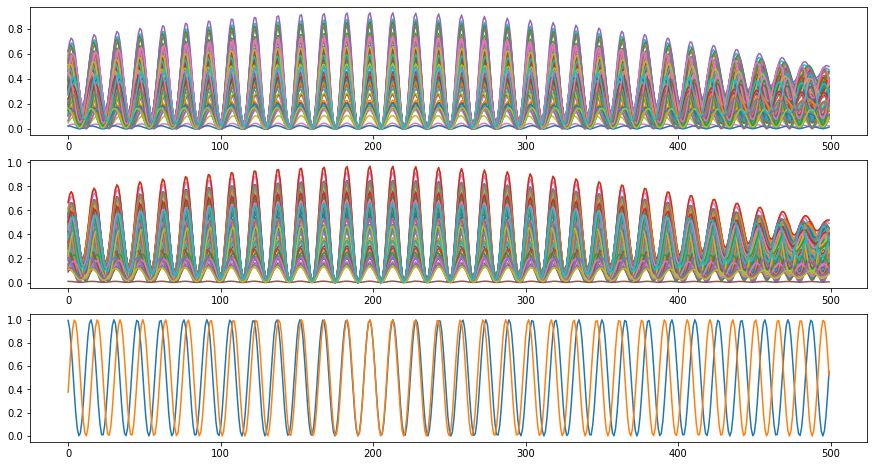

In [10]:
plt.figure(figsize=(15,8))
plt.subplot(311)
plt.plot(rates[0].numpy())
plt.subplot(312)
plt.plot(rates[1].numpy())

plt.subplot(313)
plt.plot(y_data[0].cpu().numpy());

In [11]:
prob = rates.to(device)*time_step*max_rate
mask = torch.rand((batch_size,n_steps,n_inputs), device=device, dtype=dtype)
x_data = torch.zeros((batch_size,n_steps,n_inputs), device=device, dtype=dtype)
x_data[mask<prob] = 1.0

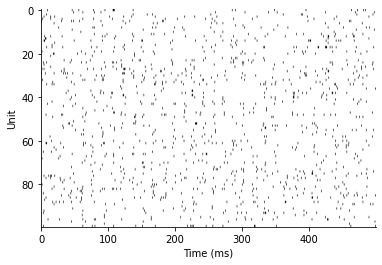

In [12]:
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

Define a helper function to visualise activity:

In [13]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5, ax=None):
    if type(ax) == type(None):
        _,ax = plt.subplots(*dim, sharey=True)
    ax = ax.flatten()
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        ax[i].plot(dat[i])
        ax[i].axis("off")
    return ax

In [14]:
model = Cortex(cortex_params)
output = model(x_data)

<Figure size 600x400 with 0 Axes>

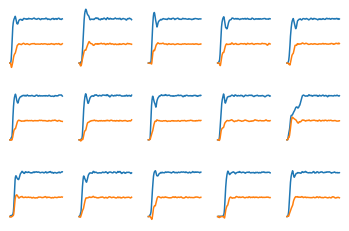

In [15]:
fig=plt.figure(dpi=100)
ax = plot_voltage_traces(output)

### Short-term synaptic plasticity
For historic interest, I am keeping a bit of code here that tries to do short-term plasticity.
We'll use the Tsodyks-Markram model of (presynaptic) short-term plasticity here, because it allows for both depression and facilitation. It's a little involved, though, so hold on to your pants. First, we'll define the parameters: A fixed use fraction U, and synapse-specific learned $\tau_{rec}$ and $\tau_{fac}$.

In [16]:
plast_params = {
    'U': 0.2, # Use fraction. We'll want to make this trainable (per projection?) later, I think.
    'tau_rec_bounds': (0.15, 1.), # Expect numeric instabilities near tau_syn==tau_rec
    'tau_fac_bounds': (0., 1.)
}

cortex_params.update(plast_params)

In [89]:
class Cortex(nn.Module):
    def __init__(self, pars):
        super(Cortex, self).__init__()
        self.pars = pars
        
        sig_lo, sig_hi = pars['sigmoid_init_bounds']
        
        # Network structure
        nested_signs = [[p['sign']] * p['n'] for p in pars['populations']]
        flat_signs = [i for part in nested_signs for i in part]
        self.w_signs = torch.tensor(flat_signs, device=device, dtype=dtype).diag()
        N = len(flat_signs)
        self.N = N
        
        
        # Weights
        w_in = torch.empty((pars['n_inputs'], N),  device=device, dtype=dtype)
        torch.nn.init.normal_(w_in, mean=0.0, std=pars['weight_scale']/np.sqrt(pars['n_inputs']))
        self.w_in = torch.nn.Parameter(w_in) # LEARN

        w = torch.empty((N, N), device=device, dtype=dtype)
        torch.nn.init.normal_(w, mean=0.0, std=pars['weight_scale']/np.sqrt(N))
        self.w = torch.nn.Parameter(w) # LEARN

        w_out = torch.empty((N, pars['n_outputs']), device=device, dtype=dtype)
        torch.nn.init.normal_(w_out, mean=0.0, std=pars['weight_scale']/np.sqrt(N))
        self.w_out = torch.nn.Parameter(w_out) # LEARN
        
        
        # Membrane time constants
        alpha_mem_tf = torch.empty((N),  device=device, dtype=dtype)
        torch.nn.init.uniform_(alpha_mem_tf, sig_lo, sig_hi)
        self.alpha_mem_tf = torch.nn.Parameter(alpha_mem_tf) # LEARN
        self.alpha_mem_bounds = tuple(map(decayconst_s, pars['tau_mem_bounds']))
        
        self.alpha_mem_out = decayconst_s(pars['tau_mem_out'])
        
        
        # Synaptic time constants
        self.alpha_syn_in = decayconst_s(pars['tau_syn_in'])
        
        tau_syn_tf = torch.empty((N, N), device=device, dtype=dtype)
        torch.nn.init.uniform_(tau_syn_tf, sig_lo, sig_hi)
        self.tau_syn_tf = torch.nn.Parameter(tau_syn_tf) # LEARN
        
        self.alpha_syn_out = decayconst_s(pars['tau_syn_out'])
        
    
        # Short-term synaptic plasticity
        tau_rec_tf = torch.empty((N, N), device=device, dtype=dtype)
        torch.nn.init.uniform_(tau_rec_tf, sig_lo, sig_hi)
        self.tau_rec_tf = torch.nn.Parameter(tau_rec_tf) # LEARN
        
        tau_fac_tf = torch.empty((N, N), device=device, dtype=dtype)
        torch.nn.init.uniform_(tau_fac_tf, sig_lo, sig_hi)
        self.tau_fac_tf = torch.nn.Parameter(tau_fac_tf) # LEARN
        
    def forward(self, inputs):
        bs = self.pars['batch_size']
        
        # Compute the input currents
        h1 = torch.einsum("abc,cd->abd", (inputs, self.w_in))

        # Zero-initialise state variables
        syn_in = torch.zeros((bs,self.N), device=device, dtype=dtype)
        syn_r = torch.zeros((bs,self.N,self.N), device=device, dtype=dtype)
        mem = torch.zeros((bs,self.N), device=device, dtype=dtype)
        out = torch.zeros((bs,self.N), device=device, dtype=dtype)
        
        # Short-term plasticity states
        tm_x = torch.ones((bs,self.N,self.N), device=device, dtype=dtype) # x: available transmitter
        tm_u = torch.zeros((bs,self.N,self.N), device=device, dtype=dtype) # u: effective use
        lastspike = torch.zeros((bs,self.N), device=device, dtype=dtype) # time of last spike

        # Add Dale's Law signs to recurrent weights and add batch dimension
        w_r = torch.matmul(self.w_signs, torch.abs(self.w)).unsqueeze(0)

        # Transform time constants and add batch dimension
        tau_rec = sigmoid_project(self.tau_rec_tf, self.pars['tau_rec_bounds']).unsqueeze(0)
        tau_fac = sigmoid_project(self.tau_fac_tf, self.pars['tau_fac_bounds']).unsqueeze(0)
        tau_syn = sigmoid_project(self.tau_syn_tf, self.pars['tau_syn_bounds']).unsqueeze(0)
        alpha_syn = decayconst(time_step)(tau_syn)
        alpha_mem = sigmoid_project(self.alpha_mem_tf, self.alpha_mem_bounds).unsqueeze(0)

        # Lists to collect states
        mem_rec = []
        spk_rec = []

        # Compute hidden layer activity
        for t in range(n_steps):
            # Input PSPs
            syn_in = self.alpha_syn_in*syn_in + h1[:,t]

            # Mark spikes
            mthr = mem-1.0
            out = SurrGradSpike.apply(mthr)
            rst = torch.zeros_like(mem)
            Q = mthr > 0
            rst[Q] = 1.0

            # Integrate membrane potential
            mem = alpha_mem*mem +syn_in +torch.sum(syn_r * w_r, 1) -rst
            
            # Update short-term plasticity
            # cf. https://github.com/nest/nest-simulator/blob/v2.20.0/models/tsodyks_connection.h
            # Note, Tsodyks-Markram `y` is equivalent with (unweighted) syn_r, although the different
            # numerical integration method (step) for x and y may raise issues.
            # Indexing note:
            # Q, lastspike are size (bs, N). Since a single spike causes PSPs in N postsynaptic channels,
            # we need to expand this to Q3, which is a fancy index to all (bs,N,N) synapses that are active.
            # Further, Qi indexes the corresponding parameters for each of the synapses indexed by Q3.
            
            Q3 = torch.where(Q.unsqueeze(2).expand(-1,-1,self.N)) # (bs,N) mask -> (bs,N,N) fancy index
            Qi = (torch.zeros_like(Q3[0]), Q3[1], Q3[2])
            h = t - lastspike[Q3[:-1]]
            A_fac = decayconst(h)(tau_fac[Qi])
            A_rec = decayconst(h)(tau_rec[Qi])
            A_syn = decayconst(h)(tau_syn[Qi])
            A_x = ( (A_rec-1.0) * tau_rec[Qi] - (A_syn-1.0) * tau_syn[Qi] ) / (tau_syn[Qi] - tau_rec[Qi])
            tm_x[Q3] += A_x * syn_r[Q3] + (1.0-A_rec) * (1.0-tm_x[Q3]-syn_r[Q3])
            tm_u[Q3] = tm_u[Q3] * A_fac + self.pars['U'] * (1.0 - tm_u[Q3])
            tm_delta = tm_u[Q3] * tm_x[Q3]
            tm_x[Q3] -= tm_delta
            lastspike[Q] = t
            
            # Integrate PSPs
            syn_r = alpha_syn * syn_r
            syn_r[Q3] += tm_delta

            # Recordings
            mem_rec.append(mem)
            spk_rec.append(out)

        # Recordings
        self.mem_rec = torch.stack(mem_rec,dim=1)
        self.spk_rec = torch.stack(spk_rec,dim=1)

        # Readout layer
        h2 = torch.einsum("abc,cd->abd", (self.spk_rec, self.w_out))
        flt = torch.zeros((bs,self.pars['n_outputs']), device=device, dtype=dtype)
        out = torch.zeros((bs,self.pars['n_outputs']), device=device, dtype=dtype)
        out_rec = []
        for t in range(n_steps):
            new_flt = self.alpha_syn_out*flt +h2[:,t]
            new_out = self.alpha_mem_out*out +flt

            flt = new_flt
            out = new_out

            out_rec.append(out)

        out_rec = torch.stack(out_rec,dim=1)
        return out_rec

In [90]:
model = Cortex(cortex_params)
output = model(x_data)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.74 GiB total capacity; 12.57 GiB already allocated; 44.44 MiB free; 14.32 GiB reserved in total by PyTorch)

In [ ]:
fig=plt.figure(dpi=100)
ax = plot_voltage_traces(output)

There's no such thing as accuracy any more, but we can look at the loss:

In [ ]:
loss_fn = torch.nn.MSELoss()
print("Mean squared error: %.3f" % loss_fn(output, y_data))

Let's add a function to inspect the gradients:

In [ ]:
from matplotlib.lines import Line2D
def get_grad_plotter(alpha = 0.1, top = 0.02):
    def plot_grads(named_parameters, ax):
        '''Plots the gradients flowing through different layers in the net during training.
        Can be used for checking for possible gradient vanishing / exploding problems.

        Usage: Plug this function in Trainer class after loss.backwards() as 
        "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
        ave_grads = []
        max_grads= []
        layers = []
        for n, p in named_parameters:
            if p.requires_grad:
                grad = p.grad.abs()
                ave_grads.append(grad.mean())
                max_grads.append(grad.max())
                layers.append(n)
        ax.bar(np.arange(len(max_grads))+.4, max_grads, alpha=alpha, width=.4, color="c")
        ax.bar(np.arange(len(max_grads)), ave_grads, alpha=alpha, width=.4, color="b")
        ax.xaxis.set_ticks(range(0,len(ave_grads), 1))
        ax.xaxis.set_ticklabels(layers, rotation="vertical")
        ax.set_ylim(top=top)
        ax.set_xlabel("Layers")
        ax.set_ylabel("Gradient")
        ax.grid(True)
        ax.legend([Line2D([0], [0], color="c", lw=4),
                   Line2D([0], [0], color="b", lw=4)], ['max-gradient', 'mean-gradient'])
        sns.despine(offset=4)
    return plot_grads

I have no idea whether this will train! Let's try.

In [ ]:
model = Cortex(cortex_params)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, betas=(0.9,0.999)) # The optimizer we are going to use

epochs, reporting_interval = 200, 20
t_forward = t_backward = overhead = 0
tic = time.perf_counter()

ax = plt.figure().subplots()
plot_grad = get_grad_plotter(top=.05)

# The optimization loop
loss_hist = []
for e in range(epochs):
    # run the network and get output
    overhead += time.perf_counter() - tic
    tic = time.perf_counter()
    
    output = model(x_data)
    
    toc = time.perf_counter()
    t_forward += toc-tic
    
    # compute the loss
    loss_val = loss_fn(output, y_data)

    # update the weights
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
    tic = time.perf_counter()
    t_backward += tic-toc
    
    # store loss value
    loss_hist.append(loss_val.item())
    
    if e%reporting_interval == 0:
        plot_grad(model.named_parameters(), ax)
        fig=plt.figure(dpi=100)
        plot_voltage_traces(output,dim=(1,5))
        if e > 0:
            t_forward /= reporting_interval
            t_backward /= reporting_interval
            overhead /= reporting_interval
        print("Forward, backward, overhead: %0.3f s; %0.3f s; %0.3f s" % (t_forward, t_backward, overhead))
        t_forward = t_backward = overhead = 0

In [ ]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()
print(loss_hist[-1])

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(output[:,:,1].detach().cpu().numpy().T);
plt.plot(y_data[0,:,1].cpu().numpy(), color='black')

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(output[:,:,0].detach().cpu().numpy().T);
plt.plot(y_data[0,:,0].cpu().numpy(), color='black')